In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-21 20:59:43.967282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 20:59:43.967355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
import scanpy as sc

babel_dir = '../babel_data/DM_rep4/'
train = sc.read_h5ad(babel_dir + 'train_rna.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_rna.h5ad').X.toarray()
data1 = np.concatenate([train, valid], axis=0)
fnames1 = np.array(v)

train = sc.read_h5ad(babel_dir + 'train_atac.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_atac.h5ad').X.toarray()
data2 = np.concatenate([train, valid], axis=0)
fnames2 = np.array(v)

split = train.shape[0]

/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dataset_name = 'DM_rep4'
modality_names = ['RNA', 'ATAC']

# data1 = PCA(n_components=32).fit_transform(data1)
# data2 = PCA(n_components=32).fit_transform(data2)
# fnames1 = fnames2 = None

type1 = np.array(len(data1) * ['Cell Type 0'])
type2 = np.array(len(data2) * ['Cell Type 0'])

# Sampling
sample_num = split
# split = 500
data_col_idx = np.random.choice(range(split), sample_num, replace=False)
data1, data2, type1, type2 = (x[list(data_col_idx) + list(range(split, len(data1)))] for x in (data1, data2, type1, type2))
split = sample_num

# Labels
labels = [type1, type2]
features = [list(fnames1), list(fnames2)]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

In [6]:
# Train-Test Imputation
train_idx = np.array(list(range(split)))
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [7]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 32
pca_dim = [256] * 2
dist_method = 'euclidean'

# ComManDo

In [8]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': int(1e7),
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, kwargs_str])

In [16]:
# Imputation
cm_im = ComManDo(**kwargs, match_result=[np.zeros([split for d in dataset])])
model_str = 'saved_models/' + hash_str + '.h5'
try:
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (3877, 34861)
Dataset 1: (3877, 85596)
---------------------------------
Train coupled autoencoders
epoch:[500/10000000]: loss:1.070870
epoch:[1000/10000000]: loss:0.831965
epoch:[1500/10000000]: loss:0.790621
epoch:[2000/10000000]: loss:0.757779
epoch:[2500/10000000]: loss:0.715417
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.0028369470092002302
Correspondence: 0.11163462400145363
Mapping: 4371.130371299994
Total: 4371.244842871005



# Comparison Methods

In [17]:
# Imputation
if True:
    imputation_name = 'Babel'
    bdata1 = sc.read_h5ad(babel_dir + 'atac_rna_test_preds.h5ad').X.toarray()
    bdata2 = sc.read_h5ad(babel_dir + 'rna_atac_test_preds.h5ad').X.toarray()
    nn_imputed = [bdata1, bdata2]
else:
    imputation_name = 'NN'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [18]:
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]
colors = ['blue', 'red', 'teal']
style='whitegrid'

sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

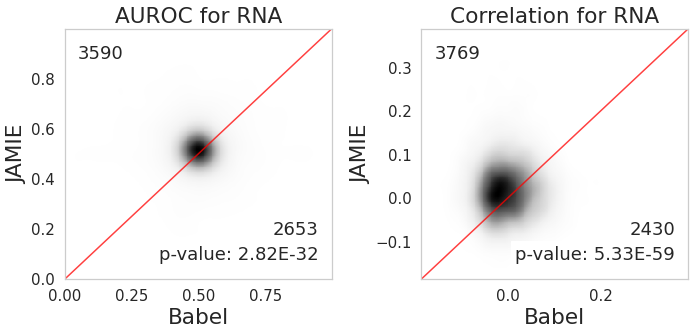

In [19]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

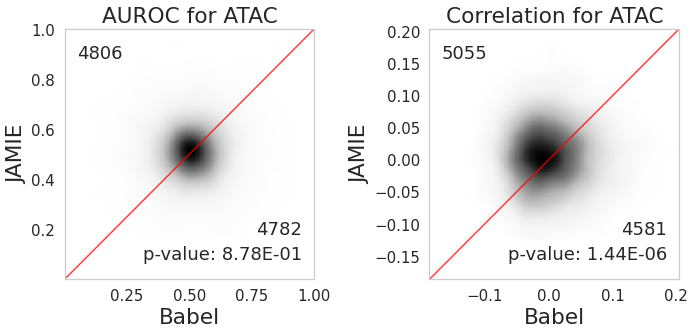

In [20]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

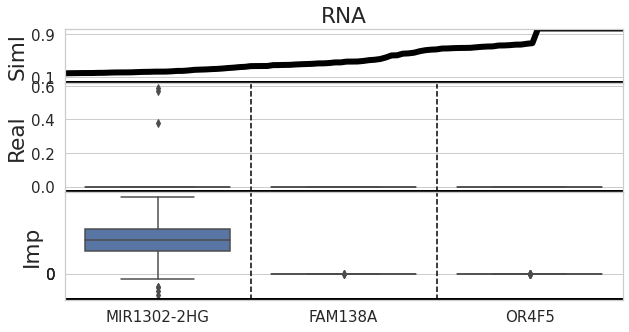

In [21]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300)

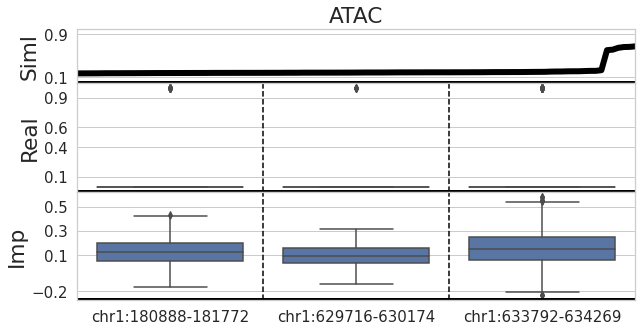

In [22]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300)

# Explanation

In [ ]:
# RNA (Place) -> ATAC
# ATP13A3 (19) -> chr3:56205067-56205903
# CUEDC1 (7) -> chr17:49987534-49988591

In [ ]:
mod0, mod1 = 1, 0

In [83]:
from commando.utilities import sort_by_interest

order, interest = sort_by_interest([cm_imputed[mod1], dataset[mod1][test_idx]], limit=10)
order_str = ', '.join([str(n) for n in order[:10]])
order_names_str = ', '.join(features[mod1][order[:10]])
print(f'Top performing features for SHAP:\n{order_names_str}\n{order_str}')
print()
interest_str = ', '.join([str(n) for n in interest[:10]])
interest_names_str = ', '.join(features[mod1][interest[:10]])
print(f'Top interesting features for SHAP:\n{interest_names_str}\n{interest_str}')

invalid value encountered in true_divide
An input array is constant; the correlation coefficient is not defined.


Top performing features for SHAP: 18404, 14412, 31651, 26558, 32408, 22405, 3753, 16231, 32984, 10479
Top interesting features for SHAP: 18404, 9082, 28141, 16220, 27529, 20355, 18578, 11797, 4857, 14345


In [ ]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = interest[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

Permutation explainer:  84%|████████████████████████████████▊      | 841/1000 [05:14<01:00,  2.61it/s]

In [ ]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

In [ ]:
shap.plots.heatmap(shap_values, max_display=display, show=False)
plt.gca().set_xlabel('Samples')
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(shap_values.abs.mean(0).values)[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

## Interactive

In [ ]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# kshap_values = kexplainer.shap_values(data, nsamples=100)

In [ ]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [ ]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)